In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import joblib

In [8]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
#Stopwords removal
stop_words = set(stopwords.words('english'))

In [10]:
def preprocess(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

In [11]:
df = pd.read_csv('data/spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']

In [12]:
df['text'] = df['text'].apply(preprocess)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [13]:
X = df['text']
y = df['label']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [16]:
#Training Process with MultinomialNB
model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

In [18]:
!mkdir model
joblib.dump(model, 'model/spam_classifier.pkl')
joblib.dump(vectorizer, 'model/vectorizer.pkl')

mkdir: cannot create directory ‘model’: File exists


['model/vectorizer.pkl']

Testing Area

In [19]:
model = joblib.load('model/spam_classifier.pkl')
vectorizer = joblib.load('model/vectorizer.pkl')

In [20]:
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
stop_words = set(stopwords.words('english'))

In [22]:
def preprocess(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

In [28]:
def plot(message):
    processed = preprocess(message)
    vectorized = vectorizer.transform([processed])
    prediction = model.predict(vectorized)[0]
    probabilities = model.predict_proba(vectorized)[0]

    labels = ['Ham', 'Spam']

    plt.figure(figsize=(6,4))
    plt.bar(labels, probabilities)
    plt.title('Prediction Probabilities')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.show()

    final_label = 'Spam' if prediction == 1 else 'Ham'
    print(f"Prediction: {final_label}")

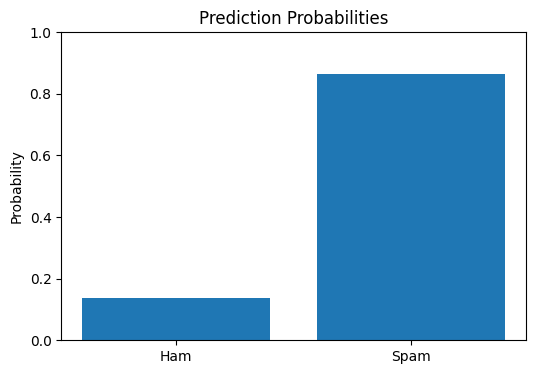

Prediction: Spam


In [29]:
message = "Congratulations! You've won a free lottery. Click here to claim now."
plot(message)

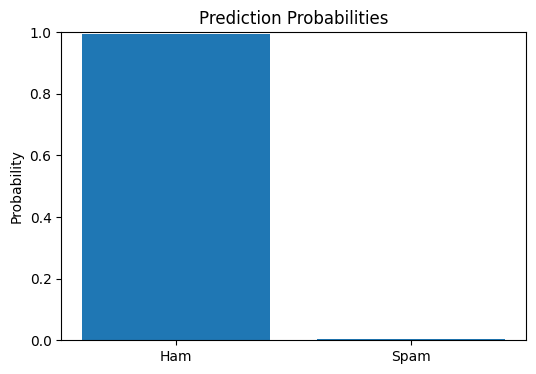

Prediction: Ham


In [30]:
message2 = "Hey Professor Cao, I forgot to do my homework today, sorry la!"
plot(message2)

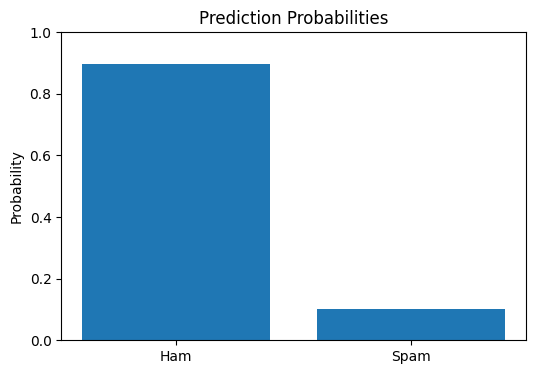

Prediction: Ham


In [34]:
message3 = "Hey Professor I forgot to do my homework today, BUT here is YOUR CHANCE to be a BIG SHOT! Call 114-514-1919810 claim NOW! "
plot(message3)

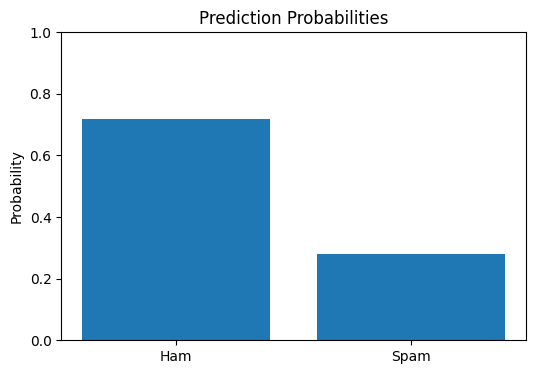

Prediction: Ham


In [39]:
message4 = "This is Amazon support. Due to security reasons, your account will be suspended unless you verify your identity immediately."
plot(message4)